<a href="https://www.kaggle.com/code/ksenia5/london-tfl-bike-scheme-2017-geospatial-analysis?scriptVersionId=121441251" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime # to manually create dates 
import matplotlib.pyplot as plt
import math

# Geospatial libraries and modules
import geopandas as gpd
import folium
from folium.features import GeoJsonTooltip
from shapely.ops import cascaded_union, unary_union, polygonize
import shapely.geometry as geometry
from shapely.geometry import Point, LineString, Polygon
!pip install geovoronoi
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords
import osmnx as ox
from scipy.spatial import Delaunay

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/kaggle/input/london-bike-sharing-system-data/journeys.csv
/kaggle/input/london-bike-sharing-system-data/stations.csv


In [2]:
# Read in data
journeys = pd.read_csv('/kaggle/input/london-bike-sharing-system-data/journeys.csv')
stations = pd.read_csv('/kaggle/input/london-bike-sharing-system-data/stations.csv')

# View data
print("Journeys data shape: ",journeys.shape)
display(journeys.head())
print("Stations data shape: ",stations.shape)
display(stations.head())

Journeys data shape:  (1542844, 14)


Journey Duration  Journey ID  End Date  End Month  End Year  End Hour  \
0            2040.0         953        19          9        17        18   
1            1800.0       12581        19          9        17        15   
2            1140.0        1159        15          9        17        17   
3             420.0        2375        14          9        17        12   
4            1200.0       14659        13          9        17        19   

   End Minute  End Station ID  Start Date  Start Month  Start Year  \
0           0             478          19            9          17   
1          21             122          19            9          17   
2           1             639          15            9          17   
3          16             755          14            9          17   
4          33             605          13            9          17   

   Start Hour  Start Minute  Start Station ID  
0          17            26               251  
1          14            51               550  
2          16            42               212  
3          12             9               163  
4          19            13                36

Stations data shape:  (773, 5)


Station ID  Capacity   Latitude  Longitude  \
0           1        19  51.529163  -0.109970   
1           2        37  51.499606  -0.197574   
2           3        32  51.521283  -0.084605   
3           4        23  51.530059  -0.120973   
4           5        27  51.493130  -0.156876   

                           Station Name  
0            River Street , Clerkenwell  
1        Phillimore Gardens, Kensington  
2  Christopher Street, Liverpool Street  
3       St. Chad's Street, King's Cross  
4         Sedding Street, Sloane Square

In [3]:
# View summary statistics
display(stations.describe())

# Relabel columns
stations.columns = ['station_id', 'capacity', 'latitude', 'longitude','station_name']
stations.head()

Station ID    Capacity    Latitude   Longitude
count  773.000000  773.000000  773.000000  773.000000
mean   412.781371   26.725744   51.506017   -0.129055
std    240.381934    9.102031    0.020103    0.055362
min      1.000000   10.000000   51.454752   -0.236769
25%    203.000000   20.000000   51.493146   -0.173656
50%    411.000000   25.000000   51.509224   -0.131213
75%    625.000000   32.000000   51.520962   -0.092940
max    826.000000   64.000000   51.549369   -0.002275

station_id  capacity   latitude  longitude  \
0           1        19  51.529163  -0.109970   
1           2        37  51.499606  -0.197574   
2           3        32  51.521283  -0.084605   
3           4        23  51.530059  -0.120973   
4           5        27  51.493130  -0.156876   

                           station_name  
0            River Street , Clerkenwell  
1        Phillimore Gardens, Kensington  
2  Christopher Street, Liverpool Street  
3       St. Chad's Street, King's Cross  
4         Sedding Street, Sloane Square

Next, create a geodataframe from stations data

In [4]:
# Add a column 'location' with latitude and longitude converted to Point geometry
stations['geometry'] = stations.apply(lambda x: Point((x.longitude, x.latitude)), axis=1)

# Set the geodata projection
london_crs = 'epsg:27700'
location_crs = 'epsg:4326'

# Make a copy of stations data and convert to geodataframe
stations_gdf = stations.copy()
stations_gdf = gpd.GeoDataFrame(stations_gdf, crs = location_crs, geometry=stations.geometry)

# View the stations dataframe and geodataframe
display(stations.head())
display(stations_gdf.head())
display(type(stations))
display(type(stations_gdf))
stations_gdf.index

# Check crs of geodataframe
# stations_gdf.crs

/opt/conda/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


station_id  capacity   latitude  longitude  \
0           1        19  51.529163  -0.109970   
1           2        37  51.499606  -0.197574   
2           3        32  51.521283  -0.084605   
3           4        23  51.530059  -0.120973   
4           5        27  51.493130  -0.156876   

                           station_name                     geometry  
0            River Street , Clerkenwell   POINT (-0.10997 51.529163)  
1        Phillimore Gardens, Kensington  POINT (-0.197574 51.499606)  
2  Christopher Street, Liverpool Street  POINT (-0.084605 51.521283)  
3       St. Chad's Street, King's Cross  POINT (-0.120973 51.530059)  
4         Sedding Street, Sloane Square   POINT (-0.156876 51.49313)

station_id  capacity   latitude  longitude  \
0           1        19  51.529163  -0.109970   
1           2        37  51.499606  -0.197574   
2           3        32  51.521283  -0.084605   
3           4        23  51.530059  -0.120973   
4           5        27  51.493130  -0.156876   

                           station_name                   geometry  
0            River Street , Clerkenwell  POINT (-0.10997 51.52916)  
1        Phillimore Gardens, Kensington  POINT (-0.19757 51.49961)  
2  Christopher Street, Liverpool Street  POINT (-0.08460 51.52128)  
3       St. Chad's Street, King's Cross  POINT (-0.12097 51.53006)  
4         Sedding Street, Sloane Square  POINT (-0.15688 51.49313)

pandas.core.frame.DataFrame

geopandas.geodataframe.GeoDataFrame

RangeIndex(start=0, stop=773, step=1)

### Calculate journey statistics

- Count the number of journeys started at each station.
- Calcullate the total journey duration for journeys started at each station.
- Append statistics to the stations geodataframe.
- Calculate journey count/ capacity for each station.

In [5]:
journey_counts = journeys.groupby(['Start Station ID']).size().to_frame()
journey_counts = journey_counts.reset_index()
journey_counts.columns = ['station_id', 'journey_count']
journey_counts['daily_journey_count'] = np.round(journey_counts['journey_count']/50,2)
display(journey_counts.head())
journey_counts.shape

station_id  journey_count  daily_journey_count
0           1           1269                25.38
1           2           2055                41.10
2           3           3337                66.74
3           4           1405                28.10
4           5           3335                66.70

(779, 3)

In [6]:
# Calcuate total journey duration in hours
total_duration = journeys.groupby(['Start Station ID'])['Journey Duration'].sum()/(60*60)
total_duration = total_duration.to_frame().reset_index()
total_duration.columns = ['station_id', 'total_duration_hours']

# Calcuate median journey duration in minutes
median_duration = np.round(journeys.groupby(['Start Station ID'])['Journey Duration'].median()/(60),1)
median_duration = median_duration.to_frame().reset_index()
median_duration.columns = ['station_id', 'median_duration_mins']

# journeys[journeys['Start Station ID'] == 2]['Journey Duration'].sum()
display(total_duration.head())
display(median_duration.head())
display(total_duration.shape)
display(median_duration.shape)
display(type(total_duration))
display(type(median_duration))

station_id  total_duration_hours
0           1            338.154444
1           2            712.716667
2           3            834.736944
3           4            456.862500
4           5           1043.140556

station_id  median_duration_mins
0           1                  11.8
1           2                  13.6
2           3                  11.2
3           4                  13.0
4           5                  13.2

(779, 2)

(779, 2)

pandas.core.frame.DataFrame

pandas.core.frame.DataFrame

In [7]:
stations_with_counts = pd.merge(stations_gdf, journey_counts, on='station_id')
stations_with_duration = pd.merge(stations_with_counts, total_duration, on='station_id')
stations_with_stats = pd.merge(stations_with_duration, median_duration, on ='station_id')
stations_with_stats['journey_count_per_cap'] = np.round(stations_with_stats['daily_journey_count']/stations_with_stats['capacity'],1)

stations_with_stats.set_index('station_id',inplace=True)
stations_with_stats = stations_with_stats.sort_index()
display(stations_with_stats)
display(stations_with_stats.shape)
type(stations_with_stats)

capacity   latitude  longitude  \
station_id                                   
1                 19  51.529163  -0.109970   
2                 37  51.499606  -0.197574   
3                 32  51.521283  -0.084605   
4                 23  51.530059  -0.120973   
5                 27  51.493130  -0.156876   
...              ...        ...        ...   
818               13  51.503127  -0.078655   
819               38  51.506210  -0.114842   
820               24  51.492807  -0.091938   
821               27  51.483507  -0.147714   
826               28  51.496863  -0.142943   

                                       station_name  \
station_id                                            
1                        River Street , Clerkenwell   
2                    Phillimore Gardens, Kensington   
3              Christopher Street, Liverpool Street   
4                   St. Chad's Street, King's Cross   
5                     Sedding Street, Sloane Square   
...                                             ...   
818                    One Tower Bridge, Bermondsey   
819                    Belvedere Road 2, South Bank   
820                         Victory Place, Walworth   
821         Battersea Power Station, Battersea Park   
826                   Allington street, Westminster   

                             geometry  journey_count  daily_journey_count  \
station_id                                                                  
1           POINT (-0.10997 51.52916)           1269                25.38   
2           POINT (-0.19757 51.49961)           2055                41.10   
3           POINT (-0.08460 51.52128)           3337                66.74   
4           POINT (-0.12097 51.53006)           1405                28.10   
5           POINT (-0.15688 51.49313)           3335                66.70   
...                               ...            ...                  ...   
818         POINT (-0.07866 51.50313)           2104                42.08   
819         POINT (-0.11484 51.50621)           2101                42.02   
820         POINT (-0.09194 51.49281)           1257                25.14   
821         POINT (-0.14771 51.48351)           1694                33.88   
826         POINT (-0.14294 51.49686)           2164                43.28   

            total_duration_hours  median_duration_mins  journey_count_per_cap  
station_id                                                                     
1                     338.154444                  11.8                    1.3  
2                     712.716667                  13.6                    1.1  
3                     834.736944                  11.2                    2.1  
4                     456.862500                  13.0                    1.2  
5                    1043.140556                  13.2                    2.5  
...                          ...                   ...                    ...  
818                  1008.139722                  16.0                    3.2  
819                   939.367778                  16.8                    1.1  
820                   416.281944                  14.7                    1.0  
821                   801.435278                  17.7                    1.3  
826                   840.238056                  18.5                    1.5  

[771 rows x 10 columns]

(771, 10)

geopandas.geodataframe.GeoDataFrame

In [8]:
# geometry_points = [Point(xy) for xy in zip(stations.longitude, stations.latitude)]


# convert points to multipoint collection and query the envelope 
# (smallest bounding rectangle that contains all station coordinates)
point_collection = geometry.MultiPoint(list(stations_with_stats.geometry))
boundary_polygon = point_collection.envelope

# Create a geodataframe with station boundary geometry
boundary_gdf = gpd.GeoDataFrame()
boundary_gdf = boundary_gdf.append({'geometry': boundary_polygon}, ignore_index=True)

# Set projection
boundary_gdf.crs = location_crs
display(boundary_gdf)

# boundary_shape = cascaded_union(boundary.geometry)
boundary_shape = unary_union(boundary_gdf.geometry)

geometry
0  POLYGON ((-0.23677 51.45475, -0.00228 51.45475...

In [9]:
# Central location on map
# map_centre = [stations.latitude.mean(), stations.longitude.mean()]
map_centre = [stations_with_stats.geometry.y.mean(), stations_with_stats.geometry.x.mean()]
# Create a base map
london_map = folium.Map(
    location= map_centre, 
    tiles='cartodbpositron', 
    zoom_start=12
)

# Add ward polygons
folium.GeoJson(boundary_gdf.geometry).add_to(london_map)

# Add station markers
for row in stations_with_stats.iterrows():
    row_values = row[1]
    location = [row_values.geometry.y,row_values.geometry.x]
    marker = folium.Circle(location=location, radius = 40, color='black', opacity=0,fill= 'black', fill_opacity = row_values['capacity']/64, popup = row_values['station_name'] + "\n"+"Capacity: "+ str(row_values['capacity']))
    marker.add_to(london_map)
    
london_map

Use the [Geovoronoi](https://pypi.org/project/geovoronoi/) function voronoi_regions_from_coords to generate voronoi poloygons for each station within a boundary

/opt/conda/lib/python3.7/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/opt/conda/lib/python3.7/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


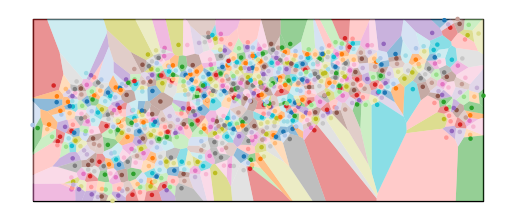

array([[-0.10997 , 51.529163],
       [-0.197574, 51.499606],
       [-0.084605, 51.521283],
       ...,
       [-0.091938, 51.492807],
       [-0.147714, 51.483507],
       [-0.142943, 51.496863]])

station_ids                                           geometry
0              1  POLYGON ((-0.11279 51.53041, -0.11274 51.52936...
1              2  POLYGON ((-0.19757 51.50282, -0.20028 51.49965...
2              3  POLYGON ((-0.08416 51.51844, -0.08431 51.51852...
3              4  POLYGON ((-0.11962 51.52969, -0.12126 51.53236...
4              5  POLYGON ((-0.15601 51.49509, -0.15846 51.49310...
..           ...                                                ...
766          818  POLYGON ((-0.07785 51.50671, -0.07969 51.50186...
767          819  POLYGON ((-0.11728 51.50730, -0.11445 51.50940...
768          820  POLYGON ((-0.09598 51.49079, -0.09613 51.48734...
769          821  POLYGON ((-0.14556 51.48622, -0.15048 51.48348...
770          826  POLYGON ((-0.14084 51.49966, -0.14158 51.50172...

[771 rows x 2 columns]

In [10]:
coords = points_to_coords(stations_with_stats.geometry)
region_polys, region_pts = voronoi_regions_from_coords(coords, boundary_shape)
fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, boundary_shape, region_polys, coords, region_pts)
plt.show()
display(coords)
vor_polys = [None]*len(region_polys)
for i in range(len(region_polys)):
    ind = region_pts[i][0]
#     display(region_polys[i])
    vor_polys[ind] = region_polys[i]

station_ids = stations_with_stats.index.to_list()
vor_df = pd.DataFrame({'station_ids':station_ids, 'geometry':vor_polys})
vor_gdf = gpd.GeoDataFrame(vor_df,crs=location_crs,geometry='geometry')
vor_gdf



<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>


/opt/conda/lib/python3.7/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/opt/conda/lib/python3.7/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


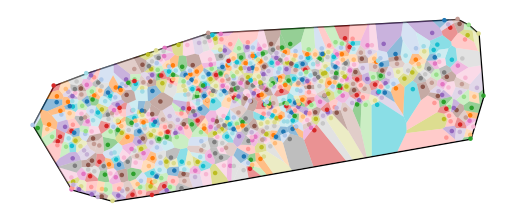

station_ids                                           geometry
0              1  POLYGON ((-0.11279 51.53041, -0.11274 51.52936...
1              2  POLYGON ((-0.19757 51.50282, -0.20028 51.49965...
2              3  POLYGON ((-0.08416 51.51844, -0.08431 51.51852...
3              4  POLYGON ((-0.11962 51.52969, -0.12126 51.53236...
4              5  POLYGON ((-0.15601 51.49509, -0.15846 51.49310...
..           ...                                                ...
766          818  POLYGON ((-0.07785 51.50671, -0.07969 51.50186...
767          819  POLYGON ((-0.11728 51.50730, -0.11445 51.50940...
768          820  POLYGON ((-0.09598 51.49079, -0.09613 51.48734...
769          821  POLYGON ((-0.14556 51.48622, -0.15048 51.48348...
770          826  POLYGON ((-0.14084 51.49966, -0.14158 51.50172...

[771 rows x 2 columns]

In [11]:
# Generate a tighter boundary using shapely's inbuilt function convex_hull
convex_hull_polygon = point_collection.convex_hull
print(type(convex_hull_polygon))
convex_hull_polygon = unary_union(convex_hull_polygon)
print(type(convex_hull_polygon))
region_polys, region_pts = voronoi_regions_from_coords(coords, convex_hull_polygon)
fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, convex_hull_polygon, region_polys, coords, region_pts)
plt.show()
vor_polys = [None]*len(region_polys)
for i in range(len(region_polys)):
    ind = region_pts[i][0]
#     display(region_polys[i])
    vor_polys[ind] = region_polys[i]

station_ids = stations_with_stats.index.to_list()
vor_df = pd.DataFrame({'station_ids':station_ids, 'geometry':vor_polys})
vor_gdf = gpd.GeoDataFrame(vor_df,crs=location_crs,geometry='geometry')
vor_gdf



Next I draw a better boundary around station locations, as outlined in [Drawing Boundaries in Python](https://thehumangeo.wordpress.com/2014/05/12/drawing-boundaries-in-python/).
<br>
This is a concave hull or alpha shape.

In [12]:
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
 
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
 
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])
 
    coords = np.array([point.coords[0] for point in points])
 
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
 
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
 
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
 
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
 
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
 
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
#     return cascaded_union(triangles), edge_points
    return unary_union(triangles), edge_points

Concave hull enclosing station coordinates:


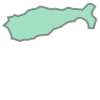

Buffered:


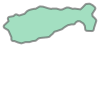

In [13]:
concave_hull, edge_points = alpha_shape(stations_with_stats.geometry, alpha=75)

print("Concave hull enclosing station coordinates:")
display(concave_hull)
print("Buffered:")
display(concave_hull.buffer(.005))

/opt/conda/lib/python3.7/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/opt/conda/lib/python3.7/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


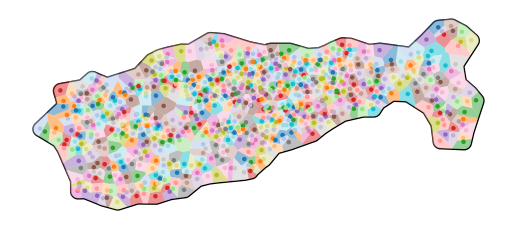

geometry
station_id                                                   
1           POLYGON ((-0.11279 51.53041, -0.11274 51.52936...
2           POLYGON ((-0.19757 51.50282, -0.20028 51.49965...
3           POLYGON ((-0.08416 51.51844, -0.08431 51.51852...
4           POLYGON ((-0.11962 51.52969, -0.12126 51.53236...
5           POLYGON ((-0.15601 51.49509, -0.15846 51.49310...
...                                                       ...
818         POLYGON ((-0.07785 51.50671, -0.07969 51.50186...
819         POLYGON ((-0.11728 51.50730, -0.11445 51.50940...
820         POLYGON ((-0.09598 51.49079, -0.09613 51.48734...
821         POLYGON ((-0.14556 51.48622, -0.15048 51.48348...
826         POLYGON ((-0.14084 51.49966, -0.14158 51.50172...

[771 rows x 1 columns]

In [14]:
# Generate a tighter boundary using shapely's inbuilt function convex_hull
# convex_hull_polygon = point_collection.convex_hull
region_polys, region_pts = voronoi_regions_from_coords(coords, concave_hull.buffer(0.004))
fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, concave_hull.buffer(0.004), region_polys, coords, region_pts)
plt.show()
vor_polys = [None]*len(region_polys)
for i in range(len(region_polys)):
    ind = region_pts[i][0]
#     display(region_polys[i])
    vor_polys[ind] = region_polys[i]

station_ids = stations_with_stats.index.to_list()
vor_df = pd.DataFrame({'station_id':station_ids, 'geometry':vor_polys})
vor_gdf = gpd.GeoDataFrame(vor_df,crs=location_crs,geometry='geometry')
vor_gdf.set_index('station_id',inplace=True)
vor_gdf = vor_gdf.sort_index()
vor_gdf


In [15]:
# Central location on map
# map_centre = [stations.latitude.mean(), stations.longitude.mean()]
map_centre = [stations_with_stats.geometry.y.mean(), stations_with_stats.geometry.x.mean()]
# Create a base map
london_map = folium.Map(
    location= map_centre, 
    tiles='cartodbpositron', 
    zoom_start=12
)

# Add ward polygons
folium.GeoJson(vor_gdf.geometry).add_to(london_map)

# Add station markers
for row in stations_with_stats.iterrows():
    row_values = row[1]
    location = [row_values.geometry.y,row_values.geometry.x]
    marker = folium.Circle(location=location, radius = 40, color='black', opacity=0,fill= 'black', fill_opacity = row_values['capacity']/64, popup = row_values['station_name'] + "\n"+"Capacity: "+ str(row_values['capacity']))
    marker.add_to(london_map)
    
london_map

In [16]:
# result = pd.merge(stations_with_stats, vor_gdf, on ='station_id')
stations_vor_stats = stations_with_stats.copy()
stations_vor_stats.geometry = vor_gdf.geometry
display(stations_vor_stats)
# display(stations_vor_stats.sort_values('journey_count_per_cap',ascending=False))

# write geojson file 
stations_vor_stats.to_file('voronoi.geojson', driver="GeoJSON") 
# geojson_fpath = '/kaggle/working/voronoi.geojson'

capacity   latitude  longitude  \
station_id                                   
1                 19  51.529163  -0.109970   
2                 37  51.499606  -0.197574   
3                 32  51.521283  -0.084605   
4                 23  51.530059  -0.120973   
5                 27  51.493130  -0.156876   
...              ...        ...        ...   
818               13  51.503127  -0.078655   
819               38  51.506210  -0.114842   
820               24  51.492807  -0.091938   
821               27  51.483507  -0.147714   
826               28  51.496863  -0.142943   

                                       station_name  \
station_id                                            
1                        River Street , Clerkenwell   
2                    Phillimore Gardens, Kensington   
3              Christopher Street, Liverpool Street   
4                   St. Chad's Street, King's Cross   
5                     Sedding Street, Sloane Square   
...                                             ...   
818                    One Tower Bridge, Bermondsey   
819                    Belvedere Road 2, South Bank   
820                         Victory Place, Walworth   
821         Battersea Power Station, Battersea Park   
826                   Allington street, Westminster   

                                                     geometry  journey_count  \
station_id                                                                     
1           POLYGON ((-0.11279 51.53041, -0.11274 51.52936...           1269   
2           POLYGON ((-0.19757 51.50282, -0.20028 51.49965...           2055   
3           POLYGON ((-0.08416 51.51844, -0.08431 51.51852...           3337   
4           POLYGON ((-0.11962 51.52969, -0.12126 51.53236...           1405   
5           POLYGON ((-0.15601 51.49509, -0.15846 51.49310...           3335   
...                                                       ...            ...   
818         POLYGON ((-0.07785 51.50671, -0.07969 51.50186...           2104   
819         POLYGON ((-0.11728 51.50730, -0.11445 51.50940...           2101   
820         POLYGON ((-0.09598 51.49079, -0.09613 51.48734...           1257   
821         POLYGON ((-0.14556 51.48622, -0.15048 51.48348...           1694   
826         POLYGON ((-0.14084 51.49966, -0.14158 51.50172...           2164   

            daily_journey_count  total_duration_hours  median_duration_mins  \
station_id                                                                    
1                         25.38            338.154444                  11.8   
2                         41.10            712.716667                  13.6   
3                         66.74            834.736944                  11.2   
4                         28.10            456.862500                  13.0   
5                         66.70           1043.140556                  13.2   
...                         ...                   ...                   ...   
818                       42.08           1008.139722                  16.0   
819                       42.02            939.367778                  16.8   
820                       25.14            416.281944                  14.7   
821                       33.88            801.435278                  17.7   
826                       43.28            840.238056                  18.5   

            journey_count_per_cap  
station_id                         
1                             1.3  
2                             1.1  
3                             2.1  
4                             1.2  
5                             2.5  
...                           ...  
818                           3.2  
819                           1.1  
820                           1.0  
821                           1.3  
826                           1.5  

[771 rows x 10 columns]

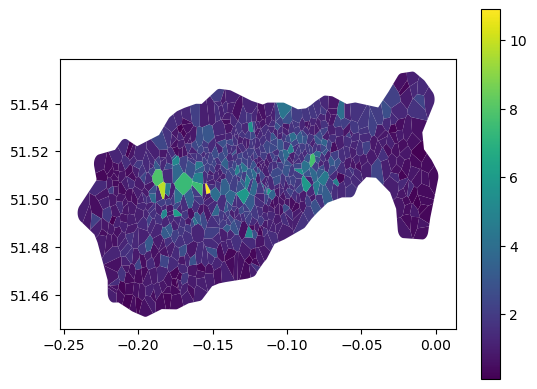

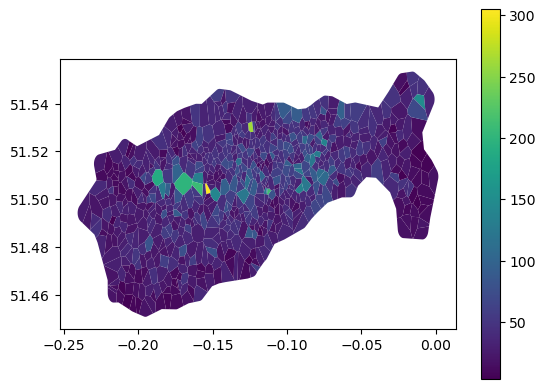

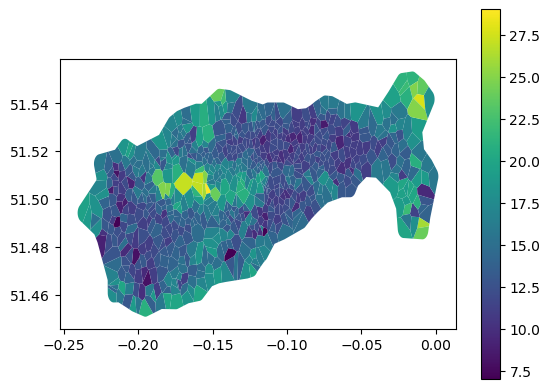

In [17]:
stations_vor_stats.plot(column='journey_count_per_cap', legend = True)
plt.show()
stations_vor_stats.plot(column='daily_journey_count', legend = True)
plt.show()
stations_vor_stats.plot(column='median_duration_mins', legend = True)
plt.show()

Bubble map showing capacity and location of each station
Opacity of circle proportional to station capacity

In [18]:
stations_with_stats['station_id'] = stations_with_stats.index.to_list()


In [19]:
london_map_0 = folium.Map(
    location= map_centre, 
#     tiles='cartodbpositron', 
    zoom_start=12
)
london_map_0.save("map0.html") #save to a file
london_map_0

In [20]:
london_map_1 = folium.Map(
    location= map_centre, 
    tiles='cartodbpositron', 
    zoom_start=12
)
london_map_1.save("map1.html") #save to a file
london_map_1

In [21]:
london_map_2 = folium.Map(
    location= map_centre, 
    tiles='cartodbpositron', 
    zoom_start=12
)

# Add station markers
for row in stations_with_stats.iterrows():
    row_values = row[1]
    location = [row_values.geometry.y,row_values.geometry.x]
    marker = folium.Circle(location=location, radius = 40, color='black', opacity=0,fill= 'black', fill_opacity = row_values['capacity']/64, popup = row_values['station_name'] + "\n"+"Capacity: "+ str(row_values['capacity']))
    marker.add_to(london_map_2)
london_map_2.save("map2.html") #save to a file
london_map_2

In [22]:
# Create a base map

london_map_v = folium.Map(
    location= map_centre, 
    tiles='cartodbpositron', 
    zoom_start=12
)

boundary_function =lambda x: {'fillColor': '#ffffff', 
                            'color':'blue', 
                            'fillOpacity': 0, 
                            'weight': 2}

# Add boundary
folium.GeoJson(concave_hull.buffer(0.004),style_function=boundary_function, name = 'Scheme boundary').add_to(london_map_v)

region_function =lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0, 
                            'weight': 0.2}
# Add ward polygons
folium.GeoJson(vor_gdf.geometry,style_function=region_function, name = 'Voronoi regions').add_to(london_map_v)

# Create choropleth
custom_scale = (stations_vor_stats['journey_count_per_cap'].quantile((0,0.25,0.5,0.75,0.9,0.995,1))).tolist()
# custom_scale = [min(stations_vor_stats['journey_count_per_cap']),100,200,300,400,500,max(stations_vor_stats['journey_count_per_cap'])]
count_per_cap = folium.Choropleth(
            geo_data=r'/kaggle/working/voronoi.geojson',
            name = 'Journey Count / Station Capacity',
            data = stations_with_stats,
            columns=['station_id','journey_count_per_cap'],  #Here we tell folium to get the county fips and plot new_cases_7days metric for each county
            key_on='feature.properties.station_id', #Here we grab the geometries/county boundaries from the geojson file using the key 'coty_code' which is the same as county fips
            threshold_scale=custom_scale, #use the custom scale we created for legend
#             fill_color='YlGnBu',
            fill_color = 'YlOrBr',
            nan_fill_color="White", #Use white color if there is no data available for the county
            fill_opacity=0.5,
            highlight=True,
            edgecolor='black',
            line_color = 'black',
            line_opacity=0.2,
            legend_name='Daily Journeys / Capacity', #title of the legend
)
count_per_cap.add_to(london_map_v)

# Create choropleth
duration_scale = (stations_vor_stats['median_duration_mins'].quantile((0,0.25,0.5,0.75,0.9,0.995,1))).tolist()
# custom_scale = [min(stations_vor_stats['journey_count_per_cap']),100,200,300,400,500,max(stations_vor_stats['journey_count_per_cap'])]
journey_duration = folium.Choropleth(
            geo_data=r'/kaggle/working/voronoi.geojson',
            name = 'Median Journey Duration (mins)',
            data = stations_with_stats,
            columns=['station_id','median_duration_mins'],  #Here we tell folium to get the county fips and plot new_cases_7days metric for each county
            key_on='feature.properties.station_id', #Here we grab the geometries/county boundaries from the geojson file using the key 'coty_code' which is the same as county fips
            threshold_scale=duration_scale, #use the custom scale we created for legend
            fill_color = 'YlGnBu',
            nan_fill_color="White", #Use white color if there is no data available for the county
            fill_opacity=0.5,
            highlight=True,
            edgecolor='black',
            line_color = 'black',
            line_opacity=0.2,
            legend_name='Journey Duration', #title of the legend
)
journey_duration.add_to(london_map_v)


# hover functionality

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    r'/kaggle/working/voronoi.geojson',
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['station_name', 'station_id', 'capacity', 'daily_journey_count','journey_count_per_cap','median_duration_mins'],  # use fields from the json file
        aliases=['Station Name: ','Station ID: ', 'Capacity: ','Daily Journeys: ',"Journeys / Capacity: ",'Median Journey Duration: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
london_map_v.add_child(NIL)
london_map_v.keep_in_front(NIL)


# Add station markers
for row in stations_with_stats.iterrows():
    row_values = row[1]
    location = [row_values.geometry.y,row_values.geometry.x]
    marker = folium.Circle(location=location, radius = 40, color='black', opacity=0,fill= 'black', fill_opacity = row_values['capacity']/64, popup = row_values['station_name'] + "\n"+"Capacity: "+ str(row_values['capacity']))
    marker.add_to(london_map_v)




#Add layer control to the map
folium.LayerControl(collapsed=False).add_to(london_map_v)
# folium.LayerControl().add_to(london_map_v)
london_map_v.save("index.html") #save to a file

london_map_v

## REFERENCES

- [Folium and Choropleth Map: From Zero to Pro](https://towardsdatascience.com/folium-and-choropleth-map-from-zero-to-pro-6127f9e68564)

- [Geovoronoi](https://pypi.org/project/geovoronoi/)
- [DRAWING BOUNDARIES IN PYTHON](https://thehumangeo.wordpress.com/2014/05/12/drawing-boundaries-in-python/)

### Further info on Voronoi regions
- [How to create Voronoi regions with Geospatial data in Python](https://towardsdatascience.com/how-to-create-voronoi-regions-with-geospatial-data-in-python-adbb6c5f2134)
- [Create a Python Voronoi Diagram with GeoPandas and Geoplot](https://wellsr.com/python/python-voronoi-diagram-with-geopandas-and-geoplot/)
- [Computing the Voronoi diagram of a set of points](https://ipython-books.github.io/145-computing-the-voronoi-diagram-of-a-set-of-points/)